## Installation & Dependencies

In [1]:
!uv pip install --system -q vllm==0.10.1.1 langgraph langchain langchain-community tavily-python python-dotenv

## Core Libraries & Environment Setup

In [ ]:

import os
import traceback
import torch
from typing import TypedDict, List, Dict
from langchain_community.llms import VLLM  # LangChain wrapper for vLLM
from langgraph.graph import StateGraph, END
from langchain_community.tools.tavily_search import TavilySearchResults
# from dotenv import load_dotenv

# # Load environment variables from .env file
# load_dotenv()


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Display GPU information
for i in range(torch.cuda.device_count()):
    gpu_name = torch.cuda.get_device_name(i)
    total_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
    print(f"\nGPU {i}: {gpu_name}")
    print(f"  Total memory: {total_memory:.2f} GB")

print("\n[SUCCESS] Setup complete")

PyTorch version: 2.7.1+cu126
CUDA available: True
Number of GPUs: 2

GPU 0: Tesla T4
  Total memory: 15.83 GB

GPU 1: Tesla T4
  Total memory: 15.83 GB

[SUCCESS] Setup complete


In [ ]:
import os
from kaggle_secrets import UserSecretsClient

os.environ["HF_TOKEN"] = UserSecretsClient().get_secret('use-public-llm')  # Hugging Face token
os.environ["TAVILY_API_KEY"] = UserSecretsClient().get_secret('tavily')    # Tavily search API key

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

## Mistral 7B Model Configuration

**Loading AWQ-quantized Mistral with optimized parameters for multi-GPU setup**

In [ ]:
print("Loading TheBloke/Mistral-7B-Instruct-v0.2-AWQ with LangChain wrapper...")
llm = VLLM(
    model="TheBloke/Mistral-7B-Instruct-v0.2-AWQ",  # 4-bit quantized Mistral 7B
    trust_remote_code=True,                          # Allow custom model code
    max_new_tokens=1024,                             # Maximum tokens to generate
    temperature=0.3,                                 # Low temperature for focused responses
    top_p=0.9,                                       # Nucleus sampling parameter
    tensor_parallel_size=2,                          # Split across 2 GPUs
    vllm_kwargs={
        "gpu_memory_utilization": 0.75,              # Use 75% of each GPU's memory
        "max_model_len": 8192,                       # Maximum context window
        "quantization": "awq",                       # AWQ 4-bit quantization
        "swap_space": 4,                             # 4GB CPU swap for KV cache overflow
        "disable_custom_all_reduce": True,           # Disable custom communication optimization
    }
)

print("[SUCCESS] Model loaded successfully!")

Loading TheBloke/Mistral-7B-Instruct-v0.2-AWQ with LangChain wrapper...


2025-10-22 01:53:24.656124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761098005.234731      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761098005.370899      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


INFO 10-22 01:53:44 [__init__.py:241] Automatically detected platform cuda.
INFO 10-22 01:53:46 [utils.py:326] non-default args: {'model': 'TheBloke/Mistral-7B-Instruct-v0.2-AWQ', 'trust_remote_code': True, 'max_model_len': 8192, 'tensor_parallel_size': 2, 'gpu_memory_utilization': 0.75, 'disable_log_stats': True, 'quantization': 'awq', 'disable_custom_all_reduce': True}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

INFO 10-22 01:54:01 [__init__.py:711] Resolved architecture: MistralForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 10-22 01:54:01 [__init__.py:1750] Using max model len 8192
WARNING 10-22 01:54:02 [__init__.py:1171] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
WARNING 10-22 01:54:02 [arg_utils.py:1770] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 10-22 01:54:08 [llm_engine.py:222] Initializing a V0 LLM engine (v0.10.1.1) with config: model='TheBloke/Mistral-7B-Instruct-v0.2-AWQ', speculative_config=None, tokenizer='TheBloke/Mistral-7B-Instruct-v0.2-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_a

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

WARNING 10-22 01:54:09 [__init__.py:2921] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
WARNING 10-22 01:54:09 [multiproc_worker_utils.py:273] Reducing Torch parallelism from 2 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
INFO 10-22 01:54:10 [cuda.py:384] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 10-22 01:54:10 [cuda.py:433] Using XFormers backend.


2025-10-22 01:54:14.136253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761098054.157020     153 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761098054.163653     153 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


INFO 10-22 01:54:19 [__init__.py:241] Automatically detected platform cuda.
(VllmWorkerProcess pid=153) INFO 10-22 01:54:20 [multiproc_worker_utils.py:219] Worker ready; awaiting tasks
(VllmWorkerProcess pid=153) INFO 10-22 01:54:21 [cuda.py:384] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
(VllmWorkerProcess pid=153) INFO 10-22 01:54:21 [cuda.py:433] Using XFormers backend.


[W1022 01:54:32.742917425 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1022 01:54:32.102801355 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W1022 01:54:42.753717184 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


(VllmWorkerProcess pid=153) INFO 10-22 01:54:52 [__init__.py:1418] Found nccl from library libnccl.so.2
(VllmWorkerProcess pid=153) INFO 10-22 01:54:52 [pynccl.py:70] vLLM is using nccl==2.26.2
INFO 10-22 01:54:52 [__init__.py:1418] Found nccl from library libnccl.so.2
INFO 10-22 01:54:52 [pynccl.py:70] vLLM is using nccl==2.26.2


[W1022 01:54:52.764200602 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


INFO 10-22 01:54:52 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1], buffer_handle=(1, 4194304, 6, 'psm_854ace0a'), local_subscribe_addr='ipc:///tmp/6b196323-7092-4c5e-b7aa-168d6a5b1205', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 10-22 01:54:52 [parallel_state.py:1134] rank 0 in world size 2 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(VllmWorkerProcess pid=153) INFO 10-22 01:54:52 [parallel_state.py:1134] rank 1 in world size 2 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
INFO 10-22 01:54:52 [model_runner.py:1080] Starting to load model TheBloke/Mistral-7B-Instruct-v0.2-AWQ...
(VllmWorkerProcess pid=153) INFO 10-22 01:54:52 [model_runner.py:1080] Starting to load model TheBloke/Mistral-7B-Instruct-v0.2-AWQ...
(VllmWorkerProcess pid=153) INFO 10-22 01:54:53 [weight_utils.py:296] Using model weights format ['*.safetensors']
INFO 10-22 01:54:53 [weight_utils.py:296] Using model weights format ['*.safe

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-22 01:55:22 [default_loader.py:262] Loading weights took 2.65 seconds
INFO 10-22 01:55:23 [model_runner.py:1112] Model loading took 1.9430 GiB and 29.099133 seconds
(VllmWorkerProcess pid=153) INFO 10-22 01:55:35 [worker.py:295] Memory profiling takes 11.98 seconds
(VllmWorkerProcess pid=153) INFO 10-22 01:55:35 [worker.py:295] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.75) = 11.06GiB
(VllmWorkerProcess pid=153) INFO 10-22 01:55:35 [worker.py:295] model weights take 1.94GiB; non_torch_memory takes 0.11GiB; PyTorch activation peak memory takes 0.52GiB; the rest of the memory reserved for KV Cache is 8.49GiB.
INFO 10-22 01:55:36 [worker.py:295] Memory profiling takes 12.08 seconds
INFO 10-22 01:55:36 [worker.py:295] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.75) = 11.06GiB
INFO 10-22 01:55:36 [worker.py:295] model weights take 1.94GiB; non_torch_memory takes 0.11GiB; PyTorch activation p

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

(VllmWorkerProcess pid=153) INFO 10-22 01:56:31 [model_runner.py:1535] Graph capturing finished in 51 secs, took 0.35 GiB
INFO 10-22 01:56:32 [model_runner.py:1535] Graph capturing finished in 51 secs, took 0.36 GiB
INFO 10-22 01:56:32 [llm_engine.py:417] init engine (profile, create kv cache, warmup model) took 68.71 seconds
INFO 10-22 01:56:32 [llm.py:298] Supported_tasks: ['generate']
[SUCCESS] Model loaded successfully!


## Web Search Configuration

In [ ]:
tavily_search = TavilySearchResults(
    max_results=10,                    # Maximum search results per query
    search_depth="advanced",           
    include_domains=[                  # Prioritize trusted football statistics sources
        "one-versus-one.com/",
        "transfermarkt.com",
        "whoscored.com", 
        "fbref.com",
        "uefa.com",
        "espn.com",
        "skysports.com",
        "statmuse.com",
        "beinsports.com",
    ],
    include_answer=True,               # Include direct answers when available
    include_raw_content=True,          # Include full page content for analysis
)

def enhanced_football_search(query: str) -> List:
    try:
        results = tavily_search.invoke(query)
        return results if isinstance(results, list) else []
    except Exception as e:
        print(f"[ERROR] Search error: {e}")
        return []

print("[SUCCESS] Search tool configured with trusted football domains")

[SUCCESS] Search tool configured with trusted football domains


/tmp/ipykernel_37/1331161840.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(


## Agent State Schema

In [ ]:
from typing import TypedDict, List, Union
import operator
from typing_extensions import Annotated

class FootballResearchState(TypedDict):
    # Query and research flow
    query: str                                    # Original user question
    reasoning_steps: List[str]                    # Breakdown of research approach
    search_queries: List[str]                     # Generated search queries
    search_results: Union[List, str]              # Raw search results or error message
    filtered_results: List                        # Filtered and ranked results
    analysis: str                                 # Content analysis summary
    final_answer: str                             # Final synthesized answer
    
    # Self-correction and retry logic
    search_visit_count: int                       # Number of search attempts
    reflection_visit_count: int                   # Number of reflection cycles
    error_history: List[str]                      # Track errors for debugging
    
    # Advanced features
    sub_queries: List[str]                        # Decomposed query components
    parallel_results: Annotated[List, operator.add]  # Accumulator for parallel searches
    extracted_data: Dict                          # Structured data extraction
    confidence_score: float                       # Answer confidence rating
    quality_check: str                            # Quality assessment result
    reflection: str                               # Quality reflection analysis

print("[SUCCESS] Agent state schema defined with comprehensive tracking")

[SUCCESS] Agent state schema defined with comprehensive tracking


## Query Reasoning Node

In [ ]:
def reasoning_node(state: FootballResearchState) -> FootballResearchState:
    """
    Analyze the user query and create a structured research plan.
    This node breaks down complex questions into manageable research components.
    """
    query = state["query"]
    
    # Create a structured prompt for query analysis
    prompt = f"""<s>[INST] You are an expert football statistics analyst.

Task: Break down this query into research steps.

Query: {query}

Provide your breakdown in this exact format:
1. Key entities: [list main players/teams/competitions]
2. Statistics needed: [list specific stats required]
3. Time periods: [identify relevant seasons/years]
4. Data sources: [where to find this data]

Be specific and concise. Maximum 5 lines total. [/INST]

Breakdown:
1."""
    
    print("Analyzing query and creating research plan...")
    response = llm.invoke(prompt)
    
    reasoning_steps = [line.strip() for line in response.split("\n") if line.strip()]
    state["reasoning_steps"] = reasoning_steps
    
    print(f"[SUCCESS] Research plan created with {len(reasoning_steps)} components")
    return state

## Search Query Planning Node

In [ ]:
def query_planner_node(state: FootballResearchState) -> FootballResearchState:
    """
    Generate specific, targeted search queries based on the reasoning analysis.
    Adapts queries if previous searches failed to find relevant results.
    """
    query = state["query"]
    reasoning_steps = state.get("reasoning_steps", [])
    
    # Check for previous failed attempts and adapt accordingly
    previous_queries = state.get("search_queries", [])
    retry_context = ""
    if previous_queries:
        retry_context = f"""
Previous queries failed to find results:
{chr(10).join(previous_queries)}

Generate DIFFERENT, more specific queries."""
    
    # Build context from reasoning analysis
    reasoning_context = ""
    if reasoning_steps:
        reasoning_context = f"""
Based on the analysis breakdown:
{chr(10).join(f"- {step}" for step in reasoning_steps)}

Use this analysis to generate focused search queries."""
    
    # Create focused prompt for query generation
    prompt = f"""<s>[INST] Break this football query into 2-4 simple sub-queries, for web search.

Original Query: {query}
{reasoning_context}

Rules:
- Each sub-query should ask ONE specific thing
- Use explicit player/team/competition names from the analysis
- Target the specific statistics and time periods identified
- Make each searchable independently
- Focus on the key entities and data sources mentioned
{retry_context}

Format: One query per line, no numbering [/INST]

Sub-queries:"""
    
    print("Generating targeted search queries...")
    response = llm.invoke(prompt)
    
    # Clean and parse the generated queries
    search_queries = [
        q.strip().lstrip('0123456789.-) ') 
        for q in response.split("\n") 
        if q.strip()
    ]
    
    state["search_queries"] = search_queries[:3]
    
    print(f"[SUCCESS] Generated {len(state['search_queries'])} search queries based on reasoning analysis:")
    for i, q in enumerate(state['search_queries'], 1):
        print(f"   {i}. {q}")
    
    return state

## Web Search Execution Nodes

In [ ]:
def parallel_search_node(state: FootballResearchState) -> FootballResearchState:
    """
    Execute a single search query as part of parallel search execution.
    LangGraph automatically parallelizes multiple instances of this node.
    """
    query = state.get("current_query", "")
    if not query:
        return {"parallel_results": []}
    
    print(f"Searching: {query}")
    results = enhanced_football_search(query)
    
    return {"parallel_results": results}


def aggregate_results_node(state: FootballResearchState) -> FootballResearchState:
    """
    Combine and deduplicate results from parallel searches.
    Implements map-reduce pattern: fan out to search, fan in to aggregate.
    """
    all_results = state.get("parallel_results", [])
    
    # Deduplicate results based on URL
    seen_urls = set()
    unique_results = []
    
    for result in all_results:
        url = result.get("url", "")
        if url and url not in seen_urls:
            seen_urls.add(url)
            unique_results.append(result)
    
    print(f"Aggregated {len(unique_results)} unique results from {len(all_results)} total")
    
    # Update state based on results
    if not unique_results:
        return {"search_results": "No results found. Re-planning needed."}
    else:
        return {"search_results": unique_results}

print("[SUCCESS] Parallel search and aggregation nodes compiled")

[SUCCESS] Parallel search and aggregation nodes compiled


## Result Filtering & Ranking Node

In [ ]:
def filter_and_rank_node(state: FootballResearchState) -> FootballResearchState:
    """
    Filter and rank search results based on source trustworthiness.
    Prioritizes results from established football statistics websites.
    """
    search_results = state["search_results"]
    
    if not isinstance(search_results, list) or not search_results:
        state["filtered_results"] = []
        print("No results to filter")
        return state

    trusted_domains = [
        'transfermarkt', 'whoscored', 'fbref', 'uefa', 'espn', 
        'skysports', 'statmuse', 'beinsports', 'one-versus-one.com'
    ]
    
    # Score each result based on domain trustworthiness
    scored_results = []
    for result in search_results:
        url = str(result.get('url', '')).lower()
        
        # Calculate trust score based on domain matches
        trust_score = sum(1 for domain in trusted_domains if domain in url)
        scored_results.append((trust_score, result))

    scored_results.sort(key=lambda x: x[0], reverse=True)
    filtered_results = [result for _, result in scored_results[:6]]
    
    state["filtered_results"] = filtered_results
    
    print(f"Filtered to {len(filtered_results)} highest-quality sources")
    
    for i, result in enumerate(filtered_results[:3], 1):
        source = result.get('url', 'Unknown source')
        title = result.get('title', 'No title')[:50]
        print(f"   {i}. {title}... ({source})")
    
    return state

## Structured Data Extraction Node

In [ ]:
def data_extraction_node(state: FootballResearchState) -> FootballResearchState:
    """
    Extract structured data from filtered search results using LLM.
    Attempts to parse football statistics into a standardized JSON format.
    """
    filtered_results = state["filtered_results"]
    
    if not filtered_results:
        state["extracted_data"] = {}
        print("No content available for data extraction")
        return state
    
    content_pieces = []
    for result in filtered_results[:3]:  # Use top 3 results
        source_url = result.get('url', 'N/A')
        content = result.get('content', result.get('raw_content', ''))[:500]
        content_pieces.append(f"Source: {source_url}\n{content}")
    
    aggregated_content = "\n\n".join(content_pieces)
    
    # Create extraction prompt
    prompt = f"""<s>[INST] Extract football statistics from these sources.

Query: {state['query']}

Sources:
{aggregated_content}

Extract ONLY factual data in this JSON format:
{{
    "player_name": "...",
    "team": "...",
    "season": "...",
    "goals": number,
    "assists": number,
    "other_stats": {{}}
}}

If data is missing, use null. Only include relevant fields. [/INST]

{{"""
    
    print("Extracting structured data from sources...")
    response = llm.invoke(prompt)
    
    # Parse the JSON response with error handling
    try:
        import json
        extracted_data = json.loads("{" + response)
        state["extracted_data"] = extracted_data
        print(f"[SUCCESS] Successfully extracted structured data")
        
        if extracted_data:
            for key, value in list(extracted_data.items())[:3]:
                print(f"   {key}: {value}")
                
    except json.JSONDecodeError as e:
        print(f"[WARNING] JSON parsing failed, storing raw response")
        state["extracted_data"] = {"raw_response": response, "parse_error": str(e)}
    except Exception as e:
        print(f"[WARNING] Data extraction error: {e}")
        state["extracted_data"] = {"error": str(e)}
    
    return state

## Content Analysis Node

In [ ]:
def content_analysis_node(state: FootballResearchState) -> FootballResearchState:
    """
    Analyze filtered content to extract key information relevant to the query.
    Focuses on finding specific statistics and facts from trusted sources.
    """
    query = state["query"]
    filtered_results = state.get("filtered_results",[])
    
    if not filtered_results:
        state["analysis"] = "No content available for analysis."
        print("No content to analyze")
        return state

    content_summaries = []
    for i, result in enumerate(filtered_results[:3], 1):  # Top 3 sources
        url = result.get('url', 'N/A')
        title = result.get('title', 'N/A')
        content = result.get('content', result.get('raw_content', 'No content'))[:800]
        
        summary = f"""Source {i}:
URL: {url}
Title: {title}
Content: {content}"""
        content_summaries.append(summary)
    
    aggregated_content = "\n\n".join(content_summaries)

    # Create focused analysis prompt
    prompt = f"""<s>[INST] You are a football statistics analyst.

Task: Extract the specific answer to this query from the sources.

Query: {query}

Sources:
{aggregated_content}

Instructions:
- Find the exact statistics requested
- Note the source for each fact
- If data is missing, state what's missing
- Be concise and factual
- Include numerical data when available

Provide your analysis in under 300 words. [/INST]

Analysis:"""
    
    print("Analyzing content for relevant information...")
    response = llm.invoke(prompt)
    
    state["analysis"] = response
    
    print(f"[SUCCESS] Content analysis complete ({len(response)} characters)")
    
    analysis_preview = response.split('\n')[0][:100]
    print(f"   Preview: {analysis_preview}...")
    
    return state

## Answer Synthesis Node

In [ ]:
def answer_synthesis_node(state: FootballResearchState) -> FootballResearchState:
    """
    Synthesize a comprehensive, well-structured final answer from the analysis.
    Creates a user-friendly response with proper context and limitations.
    """
    query = state["query"]
    analysis = state["analysis"]
    
    # Create synthesis prompt for final answer
    prompt = f"""<s>[INST] You are a helpful assistant. Create a comprehensive, well-structured answer to the query based on the analysis provided. 

Requirements:
- Provide a direct answer supported by statistics
- Add relevant context and background
- Note any limitations of the data
- Use clear, accessible language
- Structure the response logically

Query: {query}

Analysis:
{analysis}

Final Answer: [/INST]

"""
    
    print("Synthesizing comprehensive final answer...")
    response = llm.invoke(prompt)
    
    state["final_answer"] = response
    
    print(f"[SUCCESS] Final answer synthesized ({len(response)} characters)")
    
    answer_preview = response.split('\n')[0][:150]
    print(f"   Preview: {answer_preview}...")
    
    return state

print("[SUCCESS] All core analysis nodes defined and ready")

[SUCCESS] All core analysis nodes defined and ready


## Self-Correction Routing Logic

In [ ]:
def route_after_search(state: FootballResearchState) -> str:
    """
    Router function to handle search failures and implement retry logic.
    Decides whether to retry with new queries or proceed with empty results.
    
    Args:
        state: Current workflow state after search execution
        
    Returns:
        Next node name: "query_planning" for retry or "filter_rank" to proceed
    """
    search_visit_count = state.get("search_visit_count", 0)
    search_results = state["search_results"]
    
    # Check if search failed (indicated by string message instead of list)
    if isinstance(search_results, str):
        if search_visit_count <= 2:  # Maximum 2 search attempts
            print("[WARNING] Max search retries reached. Proceeding with empty results.")
            state["filtered_results"] = []
            return "content_analysis"  # Skip filtering, go straight to analysis
        
        # Retry with new queries
        print(f"Search failed (attempt {search_visit_count}/2). Retrying with different queries.")
        print(f"Search retry #{search_visit_count}")
        
        # Log the retry attempt
        error_msg = f"Search retry {search_visit_count}: {search_results}"
        state.setdefault("error_history", []).append(error_msg)
        
        return "query_planning"  # Go back to generate new queries
    
    # Search was successful, proceed normally
    print("[SUCCESS] Search successful. Proceeding to filter and rank results.")
    return "filter_rank"

In [ ]:
def confidence_scorer_node(state: FootballResearchState) -> FootballResearchState:
    """
    Calculate confidence score for the generated answer based on multiple factors.
    Provides transparency about answer reliability.
    """
    answer = state["final_answer"]
    extracted_data = state.get("extracted_data", {})
    filtered_results = state.get("filtered_results", [])
    
    confidence_score = 0.5
    
    # Boost confidence based on data quality indicators
    
    # Factor 1: Structured data extraction success
    if extracted_data and len(extracted_data) > 2:
        confidence_score += 0.2
        print("   + Structured data available (+20%)")
    
    # Factor 2: Multiple trusted sources
    if len(filtered_results) >= 3:
        confidence_score += 0.2
        print("   + Multiple sources available (+20%)")
    elif len(filtered_results) >= 1:
        confidence_score += 0.1
        print("   + Limited sources available (+10%)")
    
    # Factor 3: Answer specificity (reduce if vague)
    vague_indicators = ["might", "possibly", "unclear", "unknown", "not sure", "approximately"]
    vague_count = sum(1 for word in vague_indicators if word in answer.lower())
    
    if vague_count > 0:
        penalty = min(0.3, vague_count * 0.1)  # Max 30% penalty
        confidence_score -= penalty
        print(f"   - Vague language detected (-{penalty*100:.0f}%)")
    
    # Factor 4: Numerical data presence
    import re
    if re.search(r'\d+', answer):
        confidence_score += 0.1
        print("   + Numerical data present (+10%)")
    
    # Ensure confidence stays within valid range
    confidence_score = max(0.0, min(1.0, confidence_score))
    
    # Store confidence and enhance answer
    state["confidence_score"] = confidence_score
    state["final_answer"] = f"**Confidence: {confidence_score:.0%}**\n\n{answer}"
    
    print(f"Confidence calculated: {confidence_score:.0%}")
    
    return state

## Quality Control & Reflection Nodes

In [ ]:
def reflection_node(state: FootballResearchState) -> FootballResearchState:
    """
    Evaluate the quality of the generated answer and determine if improvements are needed.
    Implements quality control to trigger re-search if answer is inadequate.
    """
    query = state["query"]
    answer = state["final_answer"]
    
    state["reflection_visit_count"] = state.get("reflection_visit_count", 0) + 1
    
    # Create quality evaluation prompt
    prompt = f"""<s>[INST] You are a quality control expert for football statistics.

Task: Evaluate if this answer fully addresses the user's question.

Question: {query}

Answer: {answer}

Evaluation Criteria:
- Does it directly answer the question?
- Are specific statistics provided?
- Is any critical information missing?
- Are there contradictions or vague statements?

Respond in this exact format:
QUALITY: [PASS/FAIL]
REASON: [one sentence explanation]
MISSING: [list what's missing, or "None"] [/INST]

Evaluation:
QUALITY:"""
    
    print("Evaluating answer quality...")
    response = llm.invoke(prompt)
    
    state["reflection"] = response
    
    # Parse the quality assessment
    response_lines = response.split("\n")
    quality_line = response_lines[0] if response_lines else ""
    
    if "PASS" in quality_line.upper():
        state["quality_check"] = "pass"
        print("[SUCCESS] Quality check: PASSED")
    else:
        state["quality_check"] = "fail"
        print("[FAILED] Quality check: FAILED - improvements needed")
    
    # Extract reason 
    reason_lines = [line for line in response_lines if line.startswith("REASON:")]
    if reason_lines:
        reason = reason_lines[0].replace("REASON:", "").strip()
        print(f"   Reason: {reason}")
    
    # Extract missing information
    missing_lines = [line for line in response_lines if line.startswith("MISSING:")]
    if missing_lines:
        missing = missing_lines[0].replace("MISSING:", "").strip()
        if missing.lower() != "none":
            print(f"   Missing: {missing}")
        
    return state

## Post-Reflection Routing Logic

In [ ]:
def route_after_reflection(state: FootballResearchState) -> str:
    """
    Route based on quality assessment to either end workflow or retry with improvements.
    Implements reflection-based self-correction with retry limits.
    """
    quality_check = state.get("quality_check", "fail")
    reflection_visit_count = state.get("reflection_visit_count", 0)
    
    # If quality is acceptable, end the workflow
    if quality_check == "pass":
        print("Answer quality approved - workflow complete")
        return END
    
    # Check retry limits to prevent infinite reflection loops
    if reflection_visit_count <= 2:  # Allow maximum 2 reflection cycles
        print("[WARNING] Max reflection retries reached - accepting current answer")
        return END
    
    # Quality is poor and we have retries left - start over with better approach
    print(f"Quality insufficient (attempt {reflection_visit_count}/2)")
    print("Restarting research with improved strategy...")
    
    # Log the reflection retry for debugging
    error_msg = f"Reflection retry {reflection_visit_count}: Quality check failed"
    state.setdefault("error_history", []).append(error_msg)
    
    return "query_planning"  # Restart with new queries

## LangGraph Workflow Construction

[SUCCESS] Complete football research workflow created
   - Self-correcting search with retry logic
   - Parallel search execution for efficiency
   - Quality control with reflection-based improvement
   - Confidence scoring for transparency


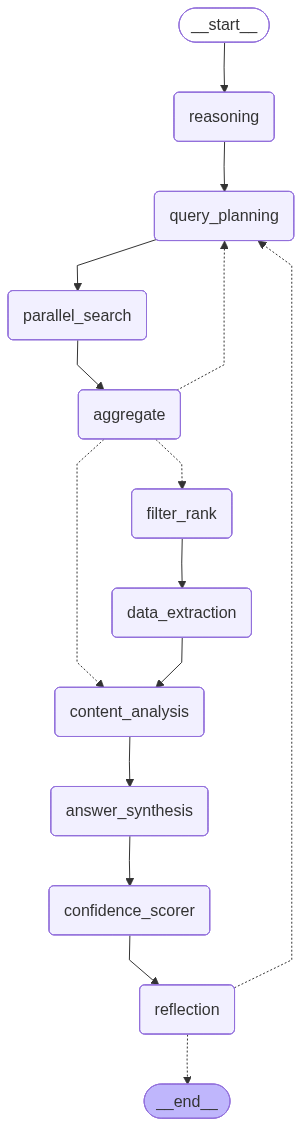

In [ ]:
def create_football_research_graph():
    """
    Create the complete self-correcting football research workflow using LangGraph.
    Implements a sophisticated pipeline with parallel search, quality control, and retry logic.
    """
    workflow = StateGraph(FootballResearchState)

    workflow.add_node("reasoning", reasoning_node)           # Query analysis and planning
    workflow.add_node("query_planning", query_planner_node)  # Generate search queries
    workflow.add_node("parallel_search", parallel_search_node)  # Execute searches in parallel
    workflow.add_node("aggregate", aggregate_results_node)   # Combine parallel results
    workflow.add_node("filter_rank", filter_and_rank_node)  # Filter by source quality
    workflow.add_node("data_extraction", data_extraction_node)  # Extract structured data
    workflow.add_node("content_analysis", content_analysis_node)  # Analyze content
    workflow.add_node("answer_synthesis", answer_synthesis_node)  # Create final answer
    workflow.add_node("confidence_scorer", confidence_scorer_node)  # Calculate confidence
    workflow.add_node("reflection", reflection_node)         # Quality control check

    workflow.set_entry_point("reasoning")                    # Start with query analysis
    workflow.add_edge("reasoning", "query_planning")         # Plan → Generate queries
    workflow.add_edge("query_planning", "parallel_search")   # Queries → Parallel search
    workflow.add_edge("parallel_search", "aggregate")        # Search → Aggregate results

    workflow.add_conditional_edges(
        "aggregate",
        route_after_search,
        {
            "query_planning": "query_planning",  # Retry with new queries if search failed
            "filter_rank": "filter_rank",        # Continue if search succeeded
            "content_analysis": "content_analysis"  # Skip filtering if no results
        }
    )

    workflow.add_edge("filter_rank", "data_extraction")      # Filter → Extract data
    workflow.add_edge("data_extraction", "content_analysis") # Extract → Analyze
    workflow.add_edge("content_analysis", "answer_synthesis") # Analyze → Synthesize
    workflow.add_edge("answer_synthesis", "confidence_scorer") # Synthesize → Score confidence
    workflow.add_edge("confidence_scorer", "reflection")     # Score → Quality check

    workflow.add_conditional_edges(
        "reflection",
        route_after_reflection,
        {
            "query_planning": "query_planning",  # Retry if quality is poor
            END: END                            # Complete if quality is acceptable
        }
    )

    return workflow.compile()

research_graph = create_football_research_graph()

print("[SUCCESS] Complete football research workflow created")
print("   - Self-correcting search with retry logic")
print("   - Parallel search execution for efficiency")  
print("   - Quality control with reflection-based improvement")
print("   - Confidence scoring")

research_graph

## Main Research Function

In [ ]:
def research_football_query(query: str) -> str:
    print("\n" + "="*80)
    print(f"FOOTBALL RESEARCH SESSION")
    print(f"Query: {query}")
    print("="*80 + "\n")

    initial_state = {
        "query": query,
        "search_visit_count": 0,
        "reflection_visit_count": 0,
        "error_history": []
    }

    try:
        print("Starting research workflow...")
        
        final_state = research_graph.invoke(initial_state)

        print("\n" + "="*80)
        print("RESEARCH COMPLETE")
        print("="*80)
        
        search_attempts = final_state.get("search_visit_count", 0)
        reflection_cycles = final_state.get("reflection_visit_count", 0)
        confidence = final_state.get("confidence_score", 0)
        
        print(f"Workflow Statistics:")
        print(f"   - Search attempts: {search_attempts}")
        print(f"   - Reflection cycles: {reflection_cycles}")
        print(f"   - Final confidence: {confidence:.0%}")
        print(f"   - Sources analyzed: {len(final_state.get('filtered_results', []))}")
        
        error_history = final_state.get("error_history", [])
        if error_history:
            print(f"   - Challenges overcome: {len(error_history)}")
        
        print("\n" + "-"*80)
        print("FINAL ANSWER:")
        print("-"*80)
        
        final_answer = final_state.get("final_answer", "No answer could be generated.")
        print(final_answer)
        
        print("\n" + "="*80 + "\n")

        return final_answer
        
    except Exception as e:
        print(f"\n[ERROR] Research workflow error: {e}")
        print("\nError details:")
        traceback.print_exc()
        
        return f"Research Error: {e}\n\nPlease try rephrasing your question or check if the required data sources are available."

print("[SUCCESS] Main research function ready for queries")

[SUCCESS] Main research function ready for queries


## Example Query 1: Player vs Team Statistics

In [ ]:
query1 = "While at Real Madrid, how many shots did Cristiano Ronaldo take against Atletico Madrid?"
answer1 = research_football_query(query1)


FOOTBALL RESEARCH SESSION
Query: While at Real Madrid, how many shots did Cristiano Ronaldo take against Atletico Madrid?

Starting research workflow...
Analyzing query and creating research plan...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Research plan created with 4 components
Generating targeted search queries...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Generated 3 search queries:
   1. How many shots did Cristiano Ronaldo take during his time at Real Madrid?
   2. Number of shots Cristiano Ronaldo took against Atletico Madrid in La Liga matches?
   3. Shots taken by Cristiano Ronaldo in El Clasico matches against Atletico Madrid at Real Madrid?
Aggregated 0 unique results from 0 total
[WARNING] Max search retries reached. Proceeding with empty results.
No content to analyze
Synthesizing comprehensive final answer...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Final answer synthesized (1952 characters)
   Preview: Cristiano Ronaldo's statistics against Atletico Madrid during his time at Real Madrid are as follows:...
   + Numerical data present (+10%)
Confidence calculated: 60%
Evaluating answer quality...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Quality check: PASSED
   Reason: The answer directly addresses the user's question by providing the number of shots and goals Cristiano Ronaldo took against Atletico Madrid in the La Liga while he was playing for Real Madrid.
   Missing: The answer could be improved by including the total number of matches played between Ronaldo and Atletico Madrid during his time at Real Madrid, or the percentage of shots on target. However, the current answer is sufficient to answer the user's question.
Answer quality approved - workflow complete

RESEARCH COMPLETE
Workflow Statistics:
   - Search attempts: 0
   - Reflection cycles: 1
   - Final confidence: 60%
   - Sources analyzed: 0

--------------------------------------------------------------------------------
FINAL ANSWER:
--------------------------------------------------------------------------------
**Confidence: 60%**

Cristiano Ronaldo's statistics against Atletico Madrid during his time at Real Madrid are as follows:

According

## Example Query 2: Specific Skill Analysis

In [ ]:
query2 = "How many times did Mbappe aim for the left side of the goal for penalties?"
answer2 = research_football_query(query2)


FOOTBALL RESEARCH SESSION
Query: How many times did Mbappe aim for the left side of the goal for penalties?

Starting research workflow...
Analyzing query and creating research plan...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Research plan created with 4 components
Generating targeted search queries...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Generated 3 search queries:
   1. How many penalties did Mbappe take in his career?
   2. In which matches did Mbappend take penalties?
   3. For the penalties taken by Mbappe, which side of the goal did he aim for?
Aggregated 0 unique results from 0 total
[WARNING] Max search retries reached. Proceeding with empty results.
No content to analyze
Synthesizing comprehensive final answer...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[SUCCESS] Final answer synthesized (1258 characters)
   Preview: Answer:...
   + Numerical data present (+10%)
Confidence calculated: 60%
Evaluating answer quality...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[FAILED] Quality check: FAILED - improvements needed
   Reason: The answer does not directly answer the question as it does not provide the number of times Mbappe aimed for the left side of the goal during penalties.
   Missing: The number of times Mbappe aimed for the left side of the goal during penalties.
[WARNING] Max reflection retries reached - accepting current answer

RESEARCH COMPLETE
Workflow Statistics:
   - Search attempts: 0
   - Reflection cycles: 1
   - Final confidence: 60%
   - Sources analyzed: 0

--------------------------------------------------------------------------------
FINAL ANSWER:
--------------------------------------------------------------------------------
**Confidence: 60%**

Answer:
Kylian Mbappe has taken a total of 13 penalties in his professional career as of now. However, the specific number of times he aimed for the left side of the goal during penalties is not readily available in the statistics.

Context and Background:
Kylian Mbappe is a French